In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from utils import (
    detrend, monthly_anomalies,
    standardize, reg_slope, corr_with_ttest,
)

In [2]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

In [3]:
eq = dict(lat=0,lon=slice(140,260))

## Load input data 

### D20 

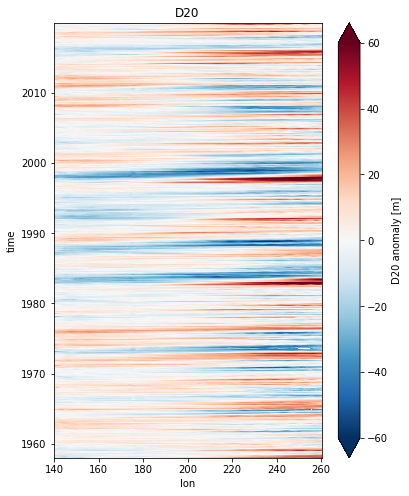

In [4]:
d20_mon_anom = monthly_anomalies(
    t_grid_file.d20.sel(**eq)
)
d20_mon_anom.attrs.update({"long_name": "D20 anomaly", "units": "m", "positive": "down"})

d20_eq = detrend(
    d20_mon_anom.fillna(0.).compute()
).rename('D20')

plt.figure(figsize=(6, 8))
d20_eq.T.plot(vmin=-60,vmax=60,cmap=plt.cm.RdBu_r)
plt.title("D20");

### SST

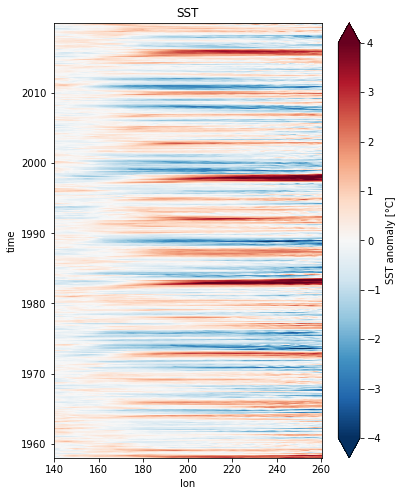

In [5]:
sst_o = t_grid_file.sosstsst.sel(**eq)

sst_mon_anom = monthly_anomalies(sst_o)
sst_mon_anom.attrs.update({"long_name": "SST anomaly", "units": "°C"})

sst_eq = detrend(sst_mon_anom.compute()).rename('SST')

plt.figure(figsize=(6, 8))
sst_eq.T.plot(vmin=-4,vmax=4,cmap=plt.cm.RdBu_r)
plt.title("SST");

### SSH 

In [6]:
ssh_o = t_grid_file.sossheig.sel(**eq)

ssh_mon_anom = monthly_anomalies(ssh_o)

ssh_mon_anom.attrs.update({"long_name": "SSH anomaly", "units": "m"})

ssh_eq = detrend(ssh_mon_anom.compute()).rename('SSH')

## Create time series

### SSH-k*D20 (linear remove effect of thermocline displacement on SSH) 

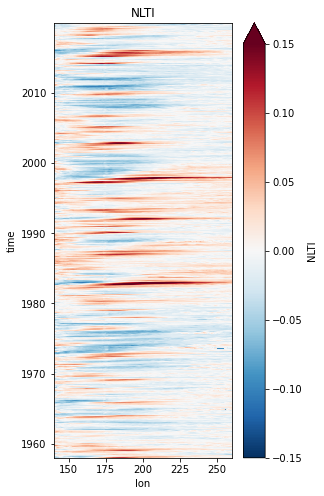

In [7]:
slope = reg_slope(d20_eq, ssh_eq, dim="time")

nlti = (
    ssh_eq - slope * d20_eq
).rename("NLTI")

nlti=detrend(
    nlti
)

plt.figure(figsize=(4, 8))
nlti.T.plot(vmin=-0.15,vmax=0.15,cmap=plt.cm.RdBu_r)
plt.title("NLTI");

## Variance

In [8]:
ds = xr.Dataset(
    {"SST": sst_eq, "D20": d20_eq, "NLTI": nlti, "SSH": ssh_eq})

ds = xr.Dataset(
    dict(
        SST=sst_eq,
        D20=d20_eq,
        NLTI=nlti,
        SSH=ssh_eq
    )
)
# use the unbiased estimator of the sample variance
variance = ds.var("time", ddof=1)
variance = variance.rename({k: f"var_{k}" for k in ("SST", "D20", "NLTI","SSH")})

## Correlations

In [9]:
sig_level = 0.95

rho_NLTI, rho_NLTI_lower, rho_NLTI_upper = corr_with_ttest(
    ds.SST, ds.NLTI,
    dim="time",
    sig=sig_level
)

rho_D20, rho_D20_lower, rho_D20_upper = corr_with_ttest(
    ds.SST, ds.D20,
    dim="time",
    sig=sig_level
)

rho_SSH, rho_SSH_lower, rho_SSH_upper = corr_with_ttest(
    ds.SST, ds.SSH,
    dim="time",
    sig=sig_level
)

correlation = xr.Dataset(
    dict(
        corr_d20_sst=rho_D20,
        corr_nlti_sst=rho_NLTI,
        corr_ssh_sst=rho_SSH,
        corr_d20_sst_lower=rho_D20_lower,
        corr_d20_sst_upper=rho_D20_upper,
        corr_nlti_sst_lower=rho_NLTI_lower,
        corr_nlti_sst_upper=rho_NLTI_upper,
        corr_ssh_sst_lower=rho_SSH_lower,
        corr_ssh_sst_upper=rho_SSH_upper,
    )
)

## Write output

In [10]:
!rm -rf data_fig3.zarr
ds.merge(variance).merge(correlation).to_zarr("data_fig3.zarr");